In [1]:
# Sample connection
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Cleaning connection")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/08/22 05:46:00 WARN Utils: Your hostname, DESKTOP-L9KIK4G resolves to a loopback address: 127.0.1.1; using 172.23.126.166 instead (on interface eth0)
22/08/22 05:46:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/22 05:46:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import numpy as np

# Linear Regression

### reading data in

In [10]:
from statsmodels.formula.api import ols, glm
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.linalg import Vectors

from pyspark.ml.regression import LinearRegression

import pandas as pd

In [6]:
sdf = spark.read.parquet('../data/curated/final3/clean_dataset.parquet/')#.drop('pickup_datetime', 'DOLocationID').dropDuplicates()
sdf.count()#.printSchema()

271934805

In [59]:
# set aside 15 days from 2019 to do our testing 
# code: https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates
import random
import time
    
def str_time_prop(start, end, time_format, prop):

    stime = time.mktime(time.strptime(start, time_format))
    etime = time.mktime(time.strptime(end, time_format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(time_format, time.localtime(ptime))


def random_date(start, end, prop):
    return str_time_prop(start, end, '%Y-%m-%d %H', prop) + ':00:00'

random.seed(42)
test_dates = [[random_date("2019-06-01 00", "2019-03-31 23", random.random())] for x in range(15)]
test_dates

[['2019-04-22 22:00:00'],
 ['2019-05-30 11:00:00'],
 ['2019-05-15 04:00:00'],
 ['2019-05-18 08:00:00'],
 ['2019-04-17 00:00:00'],
 ['2019-04-20 15:00:00'],
 ['2019-04-07 12:00:00'],
 ['2019-05-26 16:00:00'],
 ['2019-05-06 05:00:00'],
 ['2019-05-30 04:00:00'],
 ['2019-05-18 15:00:00'],
 ['2019-05-01 03:00:00'],
 ['2019-05-30 09:00:00'],
 ['2019-05-19 20:00:00'],
 ['2019-04-22 07:00:00']]

In [75]:
test_dates_df = spark.createDataFrame(test_dates, ["temp_date"]).select(F.col("temp_date"), F.to_timestamp(
    F.col("temp_date"), 'yyyy-MM-dd HH:mm:ss').alias("date")).select(F.col('date'))


In [78]:
# testing_sdf =sdf.withColumn("dt_truncated", F.date_trunc("hour", F.col("pickup_datetime")))
# testing_sdf = testing_sdf.filter(F.col('dt_truncated').isin(test_dates_df.select('date')))
# testing_sdf.write.mode('overwrite').parquet('../data/curated/testing/testing.parquet')

In [45]:
testing_sdf = spark.read.parquet('../data/curated/testing/testing.parquet')
testing_sdf.limit(5)

pickup_datetime,PULocationID,DOLocationID,PUWeekday,PUHour,PUMonth,PUDay,count,wnd,vis,tmp,dew,atm,cc,dt_truncated


In [79]:
sdf.drop('pickup_datetime','DOLocationID').dropDuplicates().write.mode('overwrite').parquet('../data/curated/training/train.parquet')

In [81]:
sdf = spark.read.parquet('../data/curated/training/train.parquet')
sdf.count()

1535071

### Encoding data

In [82]:
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler, OneHotEncoder

onehotdata = OneHotEncoder(
    inputCol='PULocationID',
    outputCol='location_vec',
    dropLast = False
).fit(sdf).transform(sdf)


assembler = VectorAssembler(
    inputCols=['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
    outputCol='features')
model_sdf = assembler.transform(onehotdata)
model_sdf.select('features').show(10, truncate=False)

+-------------------------------------------------------------------------------------------+
|features                                                                                   |
+-------------------------------------------------------------------------------------------+
|(276,[0,1,2,3,4,6,7,8,9,76],[54.0,16046.5,227.5,61.5,10132.0,6.0,6.0,2.0,3.0,1.0])         |
|(276,[0,1,2,3,4,5,6,7,8,9,230],[67.0,16093.0,194.0,50.0,10140.0,4.0,6.0,7.0,3.0,16.0,1.0]) |
|(276,[0,1,2,3,4,5,6,7,8,9,108],[62.0,16093.0,178.0,156.0,10067.0,8.0,6.0,2.0,5.0,20.0,1.0])|
|(276,[0,1,2,3,4,5,6,7,8,9,227],[48.5,16046.5,164.0,114.0,10165.5,7.0,6.0,5.0,8.0,12.0,1.0])|
|(276,[0,1,2,3,4,5,6,7,8,9,154],[26.0,16093.0,156.0,78.0,10071.0,7.0,6.0,6.0,9.0,10.0,1.0]) |
|(276,[0,1,2,3,4,5,6,7,8,9,232],[57.0,16093.0,217.0,89.0,10075.0,2.0,6.0,6.0,9.0,14.0,1.0]) |
|(276,[0,1,2,3,4,5,6,7,8,9,39],[44.0,16046.5,225.0,89.0,10075.0,2.0,6.0,6.0,9.0,15.0,1.0])  |
|(276,[0,1,2,3,4,5,6,7,8,9,20],[67.0,16093.0,306.0,117.0,101

### Normalising data

In [84]:
# NORMALIZING DATA
# code from https://stackoverflow.com/questions/40337744/scalenormalise-a-column-in-spark-dataframe-pyspark
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]), 3), DoubleType())

# Iterating over columns to be scaled
for i in ['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i], outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    model_sdf = pipeline.fit(model_sdf).transform(model_sdf).withColumn(
        i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
model_sdf.show(5)

After Scaling :


+------------+---------+------+-------+-----+-----+----+-------+-----+-----+-------+---+-----------------+--------------------+----------+----------+----------+----------+----------+---------+
|PULocationID|PUWeekday|PUHour|PUMonth|PUDay|count| wnd|    vis|  tmp|  dew|    atm| cc|     location_vec|            features|wnd_Scaled|vis_Scaled|tmp_Scaled|dew_Scaled|atm_Scaled|cc_Scaled|
+------------+---------+------+-------+-----+-----+----+-------+-----+-----+-------+---+-----------------+--------------------+----------+----------+----------+----------+----------+---------+
|        66.0|        6|     3|      6|    2|   13|54.0|16046.5|227.5| 61.5|10132.0|0.0| (266,[66],[1.0])|(276,[0,1,2,3,4,6...|     0.403|     0.997|     0.436|     0.294|      0.53|      0.0|
|       220.0|        7|    16|      6|    3|  114|67.0|16093.0|194.0| 50.0|10140.0|4.0|(266,[220],[1.0])|(276,[0,1,2,3,4,5...|       0.5|       1.0|     0.311|     0.251|     0.555|      0.0|
|        98.0|        2|    20|    

### Combining all of the data into feature vector and training model

In [86]:
df = model_sdf.drop('features')
assembler = VectorAssembler(
    inputCols=['wnd_Scaled', 'vis_Scaled', 'tmp_Scaled', 'dew_Scaled', 'atm_Scaled', 'cc_Scaled', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
    outputCol='features')
df = assembler.transform(df)


lm = LinearRegression(
    featuresCol='features', 
    labelCol='count'
).fit(df)

22/08/22 06:50:50 WARN Instrumentation: [eb082fdc] regParam is zero, which might cause numerical instability and overfitting.


22/08/22 06:51:21 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/22 06:51:21 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/08/22 06:51:22 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


22/08/22 06:51:23 WARN Instrumentation: [69b31f78] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


22/08/22 06:52:31 WARN Instrumentation: [eb082fdc] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [89]:
print("Coefficients: " + str(lm.coefficients))
print("Intercept: " + str(lm.intercept))
trainingSummary = lm.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
print('MAE', trainingSummary.meanAbsoluteError)

Coefficients: [53.99598003097942,19.29131748694818,-17.286402994995164,104.51649005953607,110.98134491798059,-60.53455641757245,-13.510755724264948,4.927122525406993,-0.06783347606503856,7.539947136485882,-186.83884382259524,-175.38154811129706,-189.30863231470886,-125.45490326882368,-21.549076357399457,-172.01247182273977,-165.72673512357377,163.00462333805885,-182.8763741108168,-154.01609205389565,-107.8995874373669,-143.71808967725545,-164.59250423856298,106.57236837338095,-29.291004213525436,-155.5715644600364,-121.26399411709288,88.14233281158542,-64.92788598354885,-157.33564317894,-103.85575428137571,-100.4213021144233,-88.96800416743403,-148.62310243818953,-93.974693639882,18.74857814665875,-53.02890779324878,-184.00642705474095,-126.73314308449417,-120.28572771733313,-184.07822422103533,-155.53635635916393,-117.21046130712028,14.795441537082652,-150.47953126587075,-24.422096314276615,69.96766895439687,139.75437812081967,-151.3782504467083,40.06455142127283,-86.68310213438832,10

+-------------------+
|          residuals|
+-------------------+
| -67.38016847216619|
|-7.5813156784774804|
| -68.38770192851376|
| 13.771355292410966|
| -6.766460222292551|
|-6.8571688360715015|
|  47.67192699721078|
| -68.23315641803009|
|  38.54788082072317|
|-12.072058135041253|
| 102.92018041167404|
|  450.1918621858111|
|  84.68817595004802|
| -66.70188330335532|
| 1073.5064088289014|
| -58.23884405388293|
|  16.55423965657952|
|  50.91125017964477|
| 12.076388411053252|
|  7.377579007417047|
+-------------------+
only showing top 20 rows

RMSE: 229.751578
r2: 0.492049
MAE 122.67263592648614


### Predicting data

In [96]:
test_df = df.limit(1)
test_df

PULocationID,PUWeekday,PUHour,PUMonth,PUDay,count,wnd,vis,tmp,dew,atm,cc,location_vec,wnd_Scaled,vis_Scaled,tmp_Scaled,dew_Scaled,atm_Scaled,cc_Scaled,features
66.0,6,3,6,2,13,54.0,16046.5,227.5,61.5,10132.0,0.0,"(266,[66],[1.0])",0.403,0.997,0.436,0.294,0.53,0.0,"(276,[0,1,2,3,4,6..."


In [99]:
lr_predictions = lm.transform(test_df)
lr_predictions.select("prediction","count","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="count",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+-----+--------------------+
|       prediction|count|            features|
+-----------------+-----+--------------------+
|80.38016847216619|   13|(276,[0,1,2,3,4,6...|
+-----------------+-----+--------------------+



R Squared (R2) on test data = -inf


# Do not look/run below

In [91]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=sampled_model_sdf.columns, outputCol=vector_col)
df_vector = assembler.transform(sampled_model_sdf).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

matrix.collect()[0]["pearson({})".format(vector_col)].values

22/08/21 18:16:15 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


array([ 1.        ,  0.10138565, -0.00554797, ..., -0.00501742,
       -0.00789543,  1.        ])

In [93]:
matrix.collect()

[Row(pearson(corr_features)=DenseMatrix(549, 549, [1.0, 0.1014, -0.0055, 0.0186, -0.0066, -0.0015, -0.0065, -0.0043, ..., -0.0058, -0.0041, -0.0009, -0.0007, -0.0007, -0.005, -0.0079, 1.0], False))]

# Statsmodel.sm. midagi ols

In [5]:
from statsmodels.formula.api import ols, glm

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [22]:
from pyspark.sql.types import DoubleType
dummy = sdf.select('count', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday','PUDay', 'PUHour', 'PULocationID')\
    .dropna('any')\
    .withColumn('count', F.col('count').cast(DoubleType()))
dummy.printSchema()


root
 |-- count: double (nullable = true)
 |-- wnd: double (nullable = true)
 |-- vis: double (nullable = true)
 |-- tmp: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- atm: double (nullable = true)
 |-- cc: double (nullable = true)
 |-- PUMonth: integer (nullable = true)
 |-- PUWeekday: integer (nullable = true)
 |-- PUDay: integer (nullable = true)
 |-- PUHour: integer (nullable = true)
 |-- PULocationID: long (nullable = true)



In [30]:
fit = smf.ols(
    formula="count ~ wnd + tmp + dew + PUMonth + PUWeekday + PUHour + PULocationID",
    #formula="count ~ wnd + vis + tmp + dew + atm + cc + PUMonth + PUWeekday + PUDay + PUHour + PULocationID",
    data=dummy.sample(withReplacement=False, fraction=0.05, seed=42).toPandas()
).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     334.5
Date:                Sun, 21 Aug 2022   Prob (F-statistic):               0.00
Time:                        23:10:08   Log-Likelihood:            -3.3138e+05
No. Observations:               52707   AIC:                         6.628e+05
Df Residuals:                   52699   BIC:                         6.628e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       25.3565      5.715      4.437      0.000      14.155      36.558
wnd              0.1355      0.032      4.298      0.000       0.074       0.197
tmp             -0.0621      0.016     -3.932      0.000      -0.093      -0.031
dew              0.0591      0.015      3.969      0.000       0.030       0.088
PUMonth         -4.0255      0.755     -5.333      0.000      -5.505      -2.546
PUWeekday        0.8561      0.283      3.025      0.002       0.301       1.411
PUHour           3.0188      0.094     32.035      0.000       2.834       3.203
PULocationID     0.2455      0.007     32.745      0.000       0.231       0.260
==============================================================================
Omnibus:                    31058.230   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           287871.698
Skew:                           2.762   Prob(JB):                         0.00
Kurtosis:                      13.029   Cond. No.                     3.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Correllation matrix

In [4]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
columns = ['PUWeekday', 'PUHour', 'PUMonth', 'PUDay', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc']
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df_vector = assembler.transform(sdf).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

22/08/21 22:59:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/21 22:59:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


<AxesSubplot:>

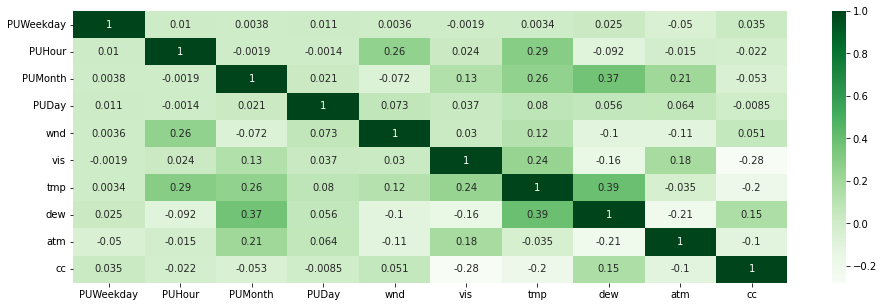

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = matrix.collect()[0][0].toArray().tolist()

corr_matrix_df = pd.DataFrame(
    data=corr_matrix,
    columns=columns,
    index=columns
)

plt.figure(figsize=(16, 5))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)


## Statsmodel by pyspark

In [7]:
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler

onehotdata = OneHotEncoder(
    inputCol='PULocationID',
    outputCol='location_vec',
    dropLast = False
).fit(sdf).transform(sdf)


assembler = VectorAssembler(
    inputCols=['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
    outputCol='features')
model_sdf = assembler.transform(onehotdata)
model_sdf.select('features').show(10, truncate=False)

# features = 'features'
# input_cols = ['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc',
#               'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec']
# assembler = VectorAssembler(
#     # which column to combine
#     inputCols=input_cols,
#     # How should the combined columns be named
#     outputCol=features
# )

# model_sdf = assembler.transform(ohe_sdf)
# # # Display the features and targets for our model
# print(model_sdf.select('features').head(2))#, model_sdf.select('count').head(5)
#model_sdf.show(200, False)

+--------------------------------------------------------------------------------------------+
|features                                                                                    |
+--------------------------------------------------------------------------------------------+
|(274,[0,1,2,3,4,5,6,7,8,9,162],[21.0,16093.0,178.0,150.0,10139.0,2.0,6.0,5.0,1.0,12.0,1.0]) |
|(274,[0,1,2,3,4,6,7,8,9,242],[41.0,16093.0,183.0,89.0,10143.0,6.0,6.0,2.0,6.0,1.0])         |
|(274,[0,1,2,3,4,6,7,8,184],[67.0,16093.0,217.0,44.0,10126.0,6.0,7.0,3.0,1.0])               |
|(274,[0,1,2,3,4,5,6,7,8,9,152],[26.0,16093.0,167.0,56.0,10145.0,4.0,6.0,7.0,3.0,8.0,1.0])   |
|(274,[0,1,2,3,4,5,6,7,8,9,231],[31.0,16093.0,189.0,61.0,10158.0,2.0,6.0,1.0,4.0,5.0,1.0])   |
|(274,[0,1,2,3,4,5,6,7,8,9,136],[41.0,16093.0,183.0,83.0,10152.0,2.0,6.0,1.0,4.0,18.0,1.0])  |
|(274,[0,1,2,3,4,5,6,7,8,9,78],[15.0,16093.0,211.0,106.0,10126.0,2.0,6.0,7.0,10.0,8.0,1.0])  |
|(274,[0,1,2,3,4,5,6,7,8,9,245],[57.0,16093.0,267.

In [8]:
df = model_sdf.sample(False, 1.0, 42)

In [183]:
df.count()

1056542

In [9]:
# NORMALIZING DATA
# code from https://stackoverflow.com/questions/40337744/scalenormalise-a-column-in-spark-dataframe-pyspark
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]), 3), DoubleType())

# Iterating over columns to be scaled
for i in ['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i], outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).withColumn(
        i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
df.show(5)


After Scaling :


+------------+---------+------+-------+-----+-----+----+-------+-----+-----+-------+---+-----------------+--------------------+----------+----------+----------+----------+----------+---------+
|PULocationID|PUWeekday|PUHour|PUMonth|PUDay|count| wnd|    vis|  tmp|  dew|    atm| cc|     location_vec|            features|wnd_Scaled|vis_Scaled|tmp_Scaled|dew_Scaled|atm_Scaled|cc_Scaled|
+------------+---------+------+-------+-----+-----+----+-------+-----+-----+-------+---+-----------------+--------------------+----------+----------+----------+----------+----------+---------+
|         152|        5|    12|      6|    1|   27|21.0|16093.0|178.0|150.0|10139.0|2.0|(264,[152],[1.0])|(274,[0,1,2,3,4,5...|     0.157|       1.0|     0.251|     0.625|     0.552|    0.222|
|         232|        6|     6|      6|    2|   10|41.0|16093.0|183.0| 89.0|10143.0|0.0|(264,[232],[1.0])|(274,[0,1,2,3,4,6...|     0.306|       1.0|      0.27|     0.397|     0.565|      0.0|
|         174|        7|     0|    

In [10]:
df = df.drop('features')
assembler = VectorAssembler(
    inputCols=['wnd_Scaled', 'vis_Scaled', 'tmp_Scaled', 'dew_Scaled', 'atm_Scaled', 'cc_Scaled', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
    outputCol='features')
thing = assembler.transform(df)

In [11]:
from pyspark.ml.regression import LinearRegression

lm = LinearRegression(
    featuresCol='features', 
    labelCol='count'
).fit(thing)

22/08/22 00:48:45 WARN Instrumentation: [03dfc9b6] regParam is zero, which might cause numerical instability and overfitting.


22/08/22 00:49:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/22 00:49:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/08/22 00:49:41 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/08/22 00:49:41 WARN Instrumentation: [03dfc9b6] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [12]:
print("Coefficients: " + str(lm.coefficients))
print("Intercept: " + str(lm.intercept))

Coefficients: [-2.758239923593503,4.8220665256658295,-27.00040306141628,18.52384101581289,2.1638891515028402,-1.2283156469220902,-5.960223409392756,1.4258592062005162,0.005259479610487974,3.7971239442345346,0.0,-71.73035471696964,-73.17803937980386,-70.73620810190165,-46.710792027588155,-68.84358523078112,-67.20521542306363,-6.741168106523943,-74.3918214076744,-76.65742955483874,-67.93354188221942,-70.77241748389693,-66.06760549348206,34.78878773034103,-69.16400861233669,-71.66034754999826,-71.10699337283705,-58.44774610066788,-71.26170358430326,-71.33730885121551,-72.22791975221367,-70.56996150520195,-69.0684322042713,-70.98246200111116,-35.187760674221906,-36.74180044531219,-71.50220447110159,-78.21340212937643,-68.88823016792553,-71.97607856898918,-74.07223747146854,-76.6196636564905,-70.25118060738102,-32.996249493334965,-79.16131013377179,-68.95971360995634,-61.587186721002546,-63.00674602311011,-67.51807741275562,-68.77053843172315,-57.563438097253645,22.694161723142763,-17.95755

In [13]:
print("Coefficients: " + str(lm.coefficients))
print("Intercept: " + str(lm.intercept))
trainingSummary = lm.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 13
objectiveHistory: [0.5000000000000001, 0.18271931788812346, 0.16380614604641935, 0.16336480272785125, 0.16318603576387963, 0.16310737861907992, 0.16309943357773465, 0.16309219942566455, 0.1630921167075951, 0.1630920761625782, 0.16309207556270977, 0.1630920755467017, 0.16309207554601923, 0.1630920755459151]


+-------------------+
|          residuals|
+-------------------+
| -6.540462607699027|
| 3.0466332368309352|
|  43.05202965635403|
|  -39.7319281514217|
|  27.44673691494159|
|-23.033258816531237|
|  -71.9067003481779|
|  35.64343753476154|
|  6.827491066599009|
|  9.680551606728478|
|-14.026275858748122|
|  51.63550311692121|
|-24.764172700419323|
|-28.567673857735976|
|-278.33310290989647|
| 6.2555744638016435|
|  78.89858988127534|
|  -5.45123378090905|
| -22.19803044799807|
| 31.130397689508932|
+-------------------+
only showing top 20 rows

RMSE: 75.448551
r2: 0.673816


In [14]:
# RMSE: 75.448525
# r2: 0.673816
print("MSE: %f" % trainingSummary.meanSquaredError)
trainingSummary.meanAbsoluteError


MSE: 5692.483895


41.49484527550178

In [35]:
from pyspark.ml.regression import GeneralizedLinearRegression

glm = GeneralizedLinearRegression(
    featuresCol='features',
    labelCol='count'
).fit(model_sdf)

22/08/21 23:14:00 WARN Instrumentation: [03c03fac] regParam is zero, which might cause numerical instability and overfitting.


22/08/21 23:14:03 WARN Instrumentation: [03c03fac] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [36]:
summary = glm.summary
# ei print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
# ei print("T Values: " + str(summary.tValues))
# ei print("P Values: " + str(summary.pValues))

print("Dispersion: " + str(summary.dispersion)) # töötas
print("Null Deviance: " + str(summary.nullDeviance)) # töötas
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull)) # töödas
print("Deviance: " + str(summary.deviance)) # töödas
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom)) # töödas
print("AIC: " + str(summary.aic)) #täädas
print("Deviance Residuals: ") 
summary.residuals().show() #täädas

Dispersion: 5693.956600470586


Null Deviance: 18438505669.75255
Residual Degree Of Freedom Null: 1056541
Deviance: 6014344150.465864
Residual Degree Of Freedom: 1056268


AIC: 12134700.679032985
Deviance Residuals: 


+-------------------+
|  devianceResiduals|
+-------------------+
|-6.5538200005479155|
| 3.0352928867120426|
|  43.04191186260306|
|  -39.7496486680277|
| 27.446033287152517|
| -23.03631618815072|
|  -71.9158846177331|
|  35.64459066348283|
|  6.835503993476124|
|  9.675370459458875|
|-14.033113931787923|
| 51.637155700582426|
|-24.762485330210566|
|-28.582318130649455|
|  -278.341656877835|
|  6.260449099064431|
|  78.89309319804966|
|-5.4471056092597365|
|-22.188966110605023|
|  31.13305648135892|
+-------------------+
only showing top 20 rows



In [44]:
model_sdf.count()

1056542

In [111]:
df2 = model_sdf.dropDuplicates()
df2.count()

19911164

## Correllation matrix with OHE

In [47]:
# cov mat with locid as onehotencoded

# convert to vector column first
columns = ['PUWeekday', 'PUHour', 'PUMonth', 'PUDay', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'location_vec']
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df_vector = assembler.transform(model_sdf).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)


22/08/21 23:27:11 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


In [49]:
corr_matrix = matrix.collect()[0][0].toArray().tolist()

In [79]:
locs = ['loc'+str(i) for i in range(1, 264)]
locs.remove('loc103')
locs.remove('loc110')
columns = ['PUWeekday', 'PUHour', 'PUMonth', 'PUDay', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc'] + locs

In [80]:
corr_matrix_df = pd.DataFrame(
    data=corr_matrix,
    columns=columns,
    index=columns
)

ValueError: 271 columns passed, passed data had 273 columns

<AxesSubplot:>

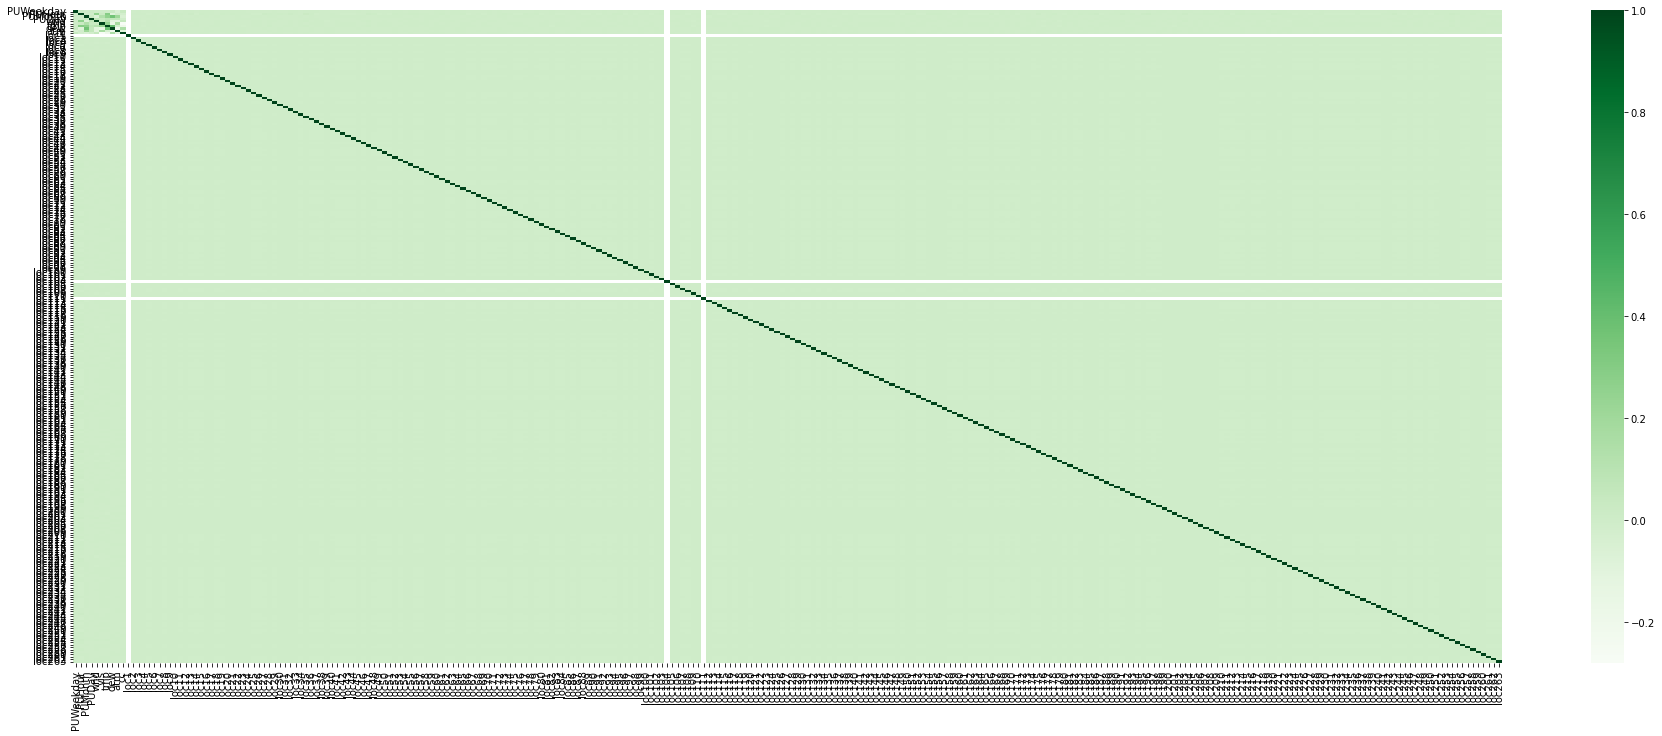

In [60]:
plt.figure(figsize=(32, 12))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=False)

In [69]:
# finding if every location appears at least once
lst = [x.PULocationID for x in model_sdf.select('PULocationID').dropDuplicates().collect()]

In [71]:
set([x for x in range(0, 265)]) - set(lst)

{0, 103, 110, 264}

# Model 2

In [ ]:
from pyspark.ml.regression import 

In [ ]:
mlpc=MultilayerPerceptronClassifier( featuresCol='features',labelCol='Class ',layers = [4,16,2],\
                                    maxIter=1000,blockSize=8,seed=7,solver='gd')